In [ ]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 71.3 MB/s eta 0:00:00


## BIGRU Implimentation

In [ ]:
!pip install scikit-learn

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import pickle

## 모델 정의

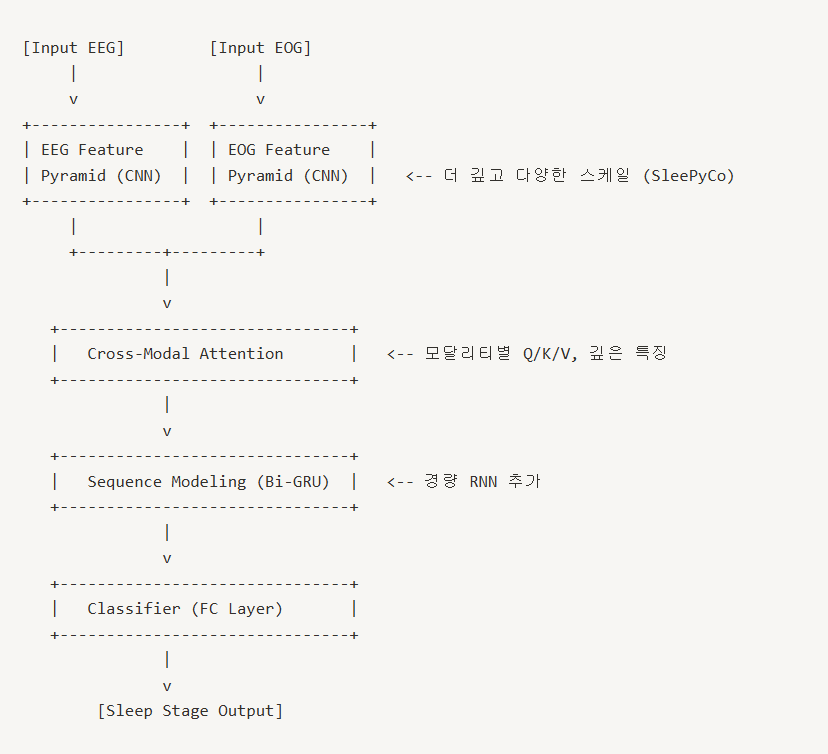

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Channel Attention
class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        scale = self.mlp(x).unsqueeze(2)
        return x * scale

# Pyramid CNN for EEG/EOG
class SignalCNN(nn.Module):
    def __init__(self, in_channels=1, base_channels=32):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(in_channels, base_channels, kernel_size=5, padding=2),
            nn.BatchNorm1d(base_channels),
            nn.PReLU(),
            ChannelGate(base_channels),
            nn.MaxPool1d(2),

            nn.Conv1d(base_channels, base_channels * 2, kernel_size=5, padding=2),
            nn.BatchNorm1d(base_channels * 2),
            nn.PReLU(),
            ChannelGate(base_channels * 2),
            nn.MaxPool1d(2),
        )

    def forward(self, x):
        return self.block(x)  # (B, 64, T//4)

# Cross-Modal Attention (Q=EEG, K/V=EOG)
class CrossModalAttention(nn.Module):
    def __init__(self, dim, heads=2):
        super().__init__()
        self.query_proj = nn.Linear(dim, dim)
        self.key_proj = nn.Linear(dim, dim)
        self.value_proj = nn.Linear(dim, dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, batch_first=True)

    def forward(self, eeg, eog):
        Q = self.query_proj(eeg)
        K = self.key_proj(eog)
        V = self.value_proj(eog)
        out, _ = self.attn(Q, K, V)
        return out

# Sequence Modeling (Bi-GRU)
class BiGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super().__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, num_layers=num_layers,
                          bidirectional=True, batch_first=True)

    def forward(self, x):
        out, _ = self.rnn(x)
        return out

# Attention Pooling + Classifier
class AttnClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.attn = nn.Linear(input_dim, 1)
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        attn_weights = torch.softmax(self.attn(x), dim=1)
        pooled = torch.sum(attn_weights * x, dim=1)
        out = self.fc(pooled)
        return out, attn_weights

# Full Model
class CSTAN_BiGRU(nn.Module):
    def __init__(self, cnn_dim=32, rnn_dim=64, num_classes=5):
        super().__init__()
        self.eeg_cnn = SignalCNN(1, cnn_dim)
        self.eog_cnn = SignalCNN(1, cnn_dim)
        self.cross_attn = CrossModalAttention(dim=cnn_dim * 2)
        self.gru = BiGRU(input_dim=cnn_dim * 2, hidden_dim=rnn_dim)
        self.classifier = AttnClassifier(input_dim=rnn_dim * 2, num_classes=num_classes)

    def forward(self, x):  # x: (B, 2, T)
        eeg = x[:, 0:1, :]
        eog = x[:, 1:2, :]

        eeg_feat = self.eeg_cnn(eeg)  # (B, C, L)
        eog_feat = self.eog_cnn(eog)

        eeg_feat = eeg_feat.transpose(1, 2)  # (B, L, C)
        eog_feat = eog_feat.transpose(1, 2)

        fused = self.cross_attn(eeg_feat, eog_feat)  # (B, L, C)
        seq_out = self.gru(fused)  # (B, L, 2H)

        out, attn = self.classifier(seq_out)  # (B, num_classes)
        return out, attn

## 데이터 합치기

In [ ]:
import os
import pickle
import torch
import numpy as np

# 🔹 병합할 pkl 경로 설정
pkl_dir = "/content/drive/MyDrive/sleep_segments"
file_list = [os.path.join(pkl_dir, f"sleep_data_part{i}.pkl") for i in range(1, 4)]

all_segments, all_labels = [], []

print("🔄 피클 파일 병합 중...")
for file in file_list:
    with open(file, 'rb') as f:
        segments, labels = pickle.load(f)
        for seg in segments:
            tensor_seg = torch.tensor(seg, dtype=torch.float32)
            if tensor_seg.ndim == 3:  # (2, 60, 50)
                tensor_seg = tensor_seg.view(2, -1)  # (2, 3000)
            all_segments.append(tensor_seg)
        all_labels.extend(labels)

all_segments = torch.stack(all_segments)  # (N, 2, T)
all_labels = torch.tensor(all_labels, dtype=torch.long)

save_path = "/content/drive/MyDrive/sleep_segments/merged_sleep_dataset.pt"
torch.save((all_segments, all_labels), save_path)
print(f"✅ 병합 완료! 저장 위치: {save_path}")

🔄 피클 파일 병합 중...
✅ 병합 완료! 저장 위치: /content/drive/MyDrive/sleep_segments/merged_sleep_dataset.pt


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np

class SleepTensorDataset(Dataset):
    def __init__(self, data_tensor, label_tensor):
        self.data = data_tensor
        self.labels = label_tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# 🔹 불러오기
merged_path = "/content/drive/MyDrive/sleep_segments/merged_sleep_dataset.pt"
print("🔄 병합된 데이터 불러오는 중...")
all_data, all_labels = torch.load(merged_path)
print(f"✅ 불러오기 완료: 총 샘플 = {len(all_data)}")

# 🔹 Train/Test Split
indices = np.arange(len(all_data))
np.random.seed(42)
np.random.shuffle(indices)
split = int(len(indices) * 0.8)
train_idx, test_idx = indices[:split], indices[split:]

train_dataset = SleepTensorDataset(all_data[train_idx], all_labels[train_idx])
test_dataset  = SleepTensorDataset(all_data[test_idx], all_labels[test_idx])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"✅ DataLoader 생성 완료: Train = {len(train_dataset)} / Test = {len(test_dataset)}")

🔄 병합된 데이터 불러오는 중...
✅ 불러오기 완료: 총 샘플 = 163698
✅ DataLoader 생성 완료: Train = 130958 / Test = 32740


## 학습 파이프라인

## 학습/평가 정의

In [ ]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in tqdm(dataloader, desc="Train"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output, _ = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        preds = output.argmax(1)
        total_loss += loss.item()
        correct += (preds == y).sum().item()
        total += y.size(0)

    acc = correct / total * 100
    return total_loss / len(dataloader), acc

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

def evaluate(model, dataloader, criterion, device):
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output, _ = model(x)
            loss = criterion(output, y)
            total_loss += loss.item()

            preds = output.argmax(dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred, average='macro')
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')

    print("\n📊 Classification Report:\n")
    print(classification_report(y_true, y_pred, digits=3))

    return total_loss / len(dataloader), acc, f1, prec, rec

In [ ]:
x_tensor, y_tensor = torch.load('/content/drive/MyDrive/sleep_segments/merged_sleep_dataset.pt')

from torch.utils.data import TensorDataset, random_split, DataLoader

dataset = TensorDataset(x_tensor, y_tensor)
train_len = int(len(dataset) * 0.8)
train_set, test_set = random_split(dataset, [train_len, len(dataset) - train_len])

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

print(f"✅ DataLoader 생성 완료: Train = {len(train_set)}개 / Test = {len(test_set)}개")

✅ DataLoader 생성 완료: Train = 261245개 / Test = 65312개


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from tqdm import tqdm

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

## 가중치 맞추는 작업

In [ ]:
#Class weights 계산 및 손실 함수 정의
y_train = [label.item() for _, label in train_set]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

## 학습

In [ ]:
# 모델, 손실 함수, 옵티마이저 정의
model = CSTAN_BiGRU().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 학습 기록
train_losses, val_losses, val_accuracies = [], [], []
all_f1, all_precision, all_recall = [], [], []

# EarlyStopping 설정
best_val_loss = float('inf')
patience = 3
patience_counter = 0
best_model_state = None

for epoch in range(1, 21):  # Epoch 20까지
    print(f"\n🌀 Epoch {epoch}")

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}%")

    val_loss, val_acc, f1, prec, rec = evaluate(model, test_loader, criterion, device)
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | F1: {f1:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f}")

    # 기록 저장
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    all_f1.append(f1)
    all_precision.append(prec)
    all_recall.append(rec)

    # EarlyStopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\n⏹️ Early stopping at epoch {epoch}. Best Val Loss: {best_val_loss:.4f}")
            break

#  가장 성능 좋았던 모델 불러오기
if best_model_state is not None:
    model.load_state_dict(best_model_state)

# 최종 성능 요약
print("\n📊 최종 모델 평가 요약:")
print(f"Average Validation Accuracy: {np.mean(val_accuracies):.2f}%")
print(f"Average Macro F1 Score: {np.mean(all_f1):.4f}")
print(f"Average Precision: {np.mean(all_precision):.4f}")
print(f"Average Recall: {np.mean(all_recall):.4f}")
print(f"Last Epoch Accuracy: {val_accuracies[-1]:.2f}% | F1: {all_f1[-1]:.4f} | Precision: {all_precision[-1]:.4f} | Recall: {all_recall[-1]:.4f}")


🌀 Epoch 1


Train: 100%|██████████| 16328/16328 [05:46<00:00, 47.07it/s]


Train Loss: 0.8496 | Train Accuracy: 79.56%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


📊 Classification Report:

              precision    recall  f1-score   support

           0      0.689     1.000     0.816     45026
           1      0.000     0.000     0.000      2973
           2      0.000     0.000     0.000     10770
           3      0.000     0.000     0.000      2341
           4      0.000     0.000     0.000      4202

    accuracy                          0.689     65312
   macro avg      0.138     0.200     0.163     65312
weighted avg      0.475     0.689     0.563     65312

Val Loss: 5.3749 | Val Acc: 68.94% | F1: 0.163 | Precision: 0.138 | Recall: 0.200

🌀 Epoch 2


Train: 100%|██████████| 16328/16328 [05:46<00:00, 47.13it/s]


Train Loss: 0.6077 | Train Accuracy: 84.94%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


📊 Classification Report:

              precision    recall  f1-score   support

           0      0.971     0.652     0.780     45026
           1      0.079     0.876     0.144      2973
           2      0.000     0.000     0.000     10770
           3      0.000     0.000     0.000      2341
           4      0.135     0.064     0.087      4202

    accuracy                          0.494     65312
   macro avg      0.237     0.318     0.202     65312
weighted avg      0.682     0.494     0.550     65312

Val Loss: 3.9769 | Val Acc: 49.36% | F1: 0.202 | Precision: 0.237 | Recall: 0.318

🌀 Epoch 3


Train: 100%|██████████| 16328/16328 [05:45<00:00, 47.23it/s]


Train Loss: 0.5553 | Train Accuracy: 86.70%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


📊 Classification Report:

              precision    recall  f1-score   support

           0      0.689     1.000     0.816     45026
           1      0.000     0.000     0.000      2973
           2      0.000     0.000     0.000     10770
           3      0.000     0.000     0.000      2341
           4      0.000     0.000     0.000      4202

    accuracy                          0.689     65312
   macro avg      0.138     0.200     0.163     65312
weighted avg      0.475     0.689     0.563     65312

Val Loss: 5.8218 | Val Acc: 68.94% | F1: 0.163 | Precision: 0.138 | Recall: 0.200

🌀 Epoch 4


Train: 100%|██████████| 16328/16328 [05:45<00:00, 47.29it/s]


Train Loss: 0.5232 | Train Accuracy: 87.68%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


📊 Classification Report:

              precision    recall  f1-score   support

           0      0.689     1.000     0.816     45026
           1      0.000     0.000     0.000      2973
           2      0.000     0.000     0.000     10770
           3      0.000     0.000     0.000      2341
           4      0.000     0.000     0.000      4202

    accuracy                          0.689     65312
   macro avg      0.138     0.200     0.163     65312
weighted avg      0.475     0.689     0.563     65312

Val Loss: 5.7624 | Val Acc: 68.94% | F1: 0.163 | Precision: 0.138 | Recall: 0.200

🌀 Epoch 5


Train: 100%|██████████| 16328/16328 [05:45<00:00, 47.22it/s]


Train Loss: 0.5033 | Train Accuracy: 88.14%

📊 Classification Report:

              precision    recall  f1-score   support

           0      0.934     0.829     0.878     45026
           1      0.098     0.839     0.176      2973
           2      0.000     0.000     0.000     10770
           3      0.000     0.000     0.000      2341
           4      0.000     0.000     0.000      4202

    accuracy                          0.610     65312
   macro avg      0.206     0.334     0.211     65312
weighted avg      0.648     0.610     0.613     65312

Val Loss: 5.1851 | Val Acc: 60.96% | F1: 0.211 | Precision: 0.206 | Recall: 0.334

⏹️ Early stopping at epoch 5. Best Val Loss: 3.9769

📊 최종 모델 평가 요약:
Average Validation Accuracy: 63.43%
Average Macro F1 Score: 0.1806
Average Precision: 0.1714
Average Recall: 0.2504
Last Epoch Accuracy: 60.96% | F1: 0.2109 | Precision: 0.2064 | Recall: 0.3335


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
print("\n🧪 테스트 세트 성능 평가:")
test_loss, test_acc, test_f1, test_prec, test_rec = evaluate(model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f} | Accuracy: {test_acc:.2f}%")
print(f"Macro F1: {test_f1:.4f} | Precision: {test_prec:.4f} | Recall: {test_rec:.4f}")


🧪 테스트 세트 성능 평가:

📊 Classification Report:

              precision    recall  f1-score   support

           0      0.934     0.829     0.878     45026
           1      0.098     0.839     0.176      2973
           2      0.000     0.000     0.000     10770
           3      0.000     0.000     0.000      2341
           4      0.000     0.000     0.000      4202

    accuracy                          0.610     65312
   macro avg      0.206     0.334     0.211     65312
weighted avg      0.648     0.610     0.613     65312

Test Loss: 5.1851 | Accuracy: 60.96%
Macro F1: 0.2109 | Precision: 0.2064 | Recall: 0.3335


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m